In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from keras.datasets import fashion_mnist

/home/benjamintan/anaconda3/envs/pyimagesearch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()

assert tf.executing_eagerly()

In [3]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

y_train = tf.cast(y_train, tf.int32)
y_test = tf.cast(y_test, tf.int32)

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [41]:
def parse_csv(line):
    example_defaults = [[0] for _ in range(785)]
    parsed_line = tf.decode_csv(line, example_defaults)
    label = tf.reshape(parsed_line[0], shape=())
    features = tf.reshape(parsed_line[1:], shape=(784, ))
    features/= 255
    return features, label

In [42]:
train_dataset = tf.data.TextLineDataset("./data/fashion-mnist_train.csv")
train_dataset = train_dataset.skip(1)
train_dataset = train_dataset.map(parse_csv)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(32)

features, label = iter(train_dataset).next()
print("Example feature:", features[0])
print("Example label:", label[0])

Example feature: tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01960784 0.31372549
 0.40392157 0.59607843 0.5372549  0.34117647 0.49411765 0.68235294
 0.68235294 0.23137255 0.01960784 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00784314 0.         0.60392157 0.87058824 0.77647059 0.84313725
 1.         0.47058824 0.90196078 0.90196078 0.85490196 0.88235294
 0.69803922 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.45490196 0.80392157 0.79215686 0.8745098  0.86666667 0.71764706
 0.81960784 0.8627451  0.81176471 0.82352941 0.61960784 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.31372549 0.69019608 0.

In [43]:
# BATCH_SIZE = 128
# SHUFFLE_SIZE = 1000

# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
#           .shuffle(SHUFFLE_SIZE) \
#           .batch(BATCH_SIZE)

# test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
#           .batch(BATCH_SIZE)

# features, label = iter(train_dataset).next()
# print("Example feature:", features[0])
# print("Example label:", label[0])

TypeError: Invalid dimensions for image data

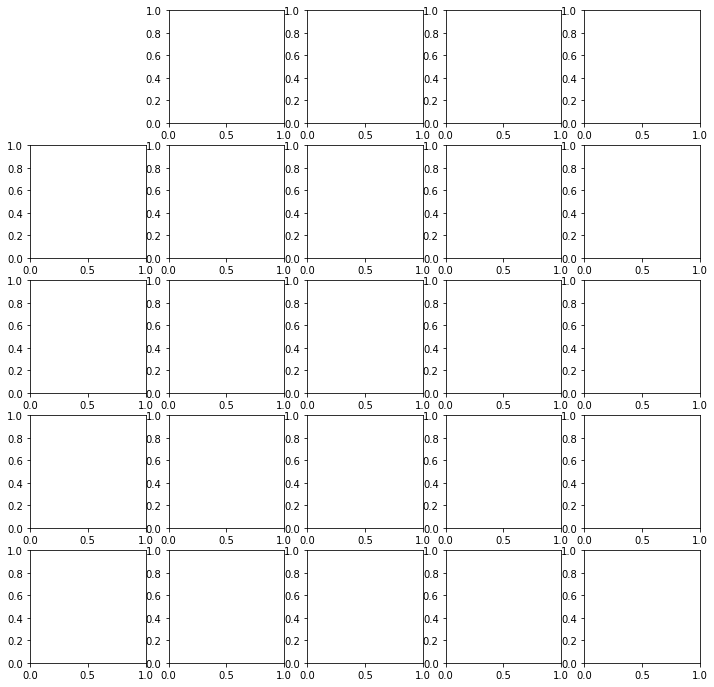

In [44]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12),)

for x in range(5):
    for y in range(5):
        axes[x][y].axis('off')
        axes[x][y].imshow(features[5*x + y], cmap='gray')

### Make Model

In [45]:
class FMNISTModel(tf.keras.Model):
    
    def __init__(self):
        super(FMNISTModel, self).__init__()
        self._input_shape = [-1, 28, 28, 1]
        self.conv1 = tf.layers.Conv2D(32, 3, 
                                      padding='same', 
                                      activation=tf.nn.relu)
        self.maxpool = tf.layers.MaxPooling2D((2, 2), 
                                              strides=(2, 2),
                                              padding='same')
        self.conv2 = tf.layers.Conv2D(64, 3, 
                                      padding='same', 
                                      activation=tf.nn.relu)
        self.conv3 = tf.layers.Conv2D(128, 3,
                                      activation=tf.nn.relu)
        self.dense1 = tf.layers.Dense(1024, activation=tf.nn.relu)
        self.dense2 = tf.layers.Dense(512, activation=tf.nn.relu)
        self.dropout = tf.layers.Dropout(0.5)
        self.dense3 = tf.layers.Dense(10)
        
    def __call__(self, inputs, training=False):
        x = tf.reshape(inputs, self._input_shape)
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = tf.layers.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x, training)
        x = self.dense2(x)
        x = self.dropout(x, training)
        x = self.dense3(x)
        return x
        
        

In [46]:
def loss(model, x, y, training):
    y_ = model(x, training=training)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

In [47]:
def grad(model, inputs, targets, training):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=training)
    return tape.gradient(loss_value, model.variables)


In [48]:
model = FMNISTModel()

In [49]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

In [50]:
## Note: Rerunning this cell uses the same model variables
from tqdm import tqdm

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 4

for epoch in tqdm(range(num_epochs)):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    # Training loop - using batches of 32
    for x, y in tfe.Iterator(train_dataset):
        # Optimize the model
        grads = grad(model, x, y, training=True)

        optimizer.apply_gradients(zip(grads, model.variables),
                                 global_step=tf.train.get_or_create_global_step())

        # Track progress
        epoch_loss_avg(loss(model, x, y, training=True))  # add current batch loss
        # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))



 25%|██▌       | 1/4 [05:13<15:40, 313.40s/it]

Epoch 000: Loss: 0.622, Accuracy: 80.268%



 50%|█████     | 2/4 [11:25<11:25, 342.63s/it]

Epoch 001: Loss: 0.384, Accuracy: 87.613%



 75%|███████▌  | 3/4 [18:27<06:09, 369.10s/it]

Epoch 002: Loss: 0.321, Accuracy: 89.548%



100%|██████████| 4/4 [26:03<00:00, 390.89s/it]


Epoch 003: Loss: 0.278, Accuracy: 90.830%
